# RNN

딥 러닝 기술의 일종인 순환 신경망(Recurrent Neural Network, RNN)을 이용한 주가 예측

RNN은 그래서 시간 개념이 들어가있는, 순차적인 데이터(=시계열 데이터)를 다루는 데에 적합
  
* **텍스트 데이터**      
    우리가 쓰는 문장을 RNN에게 사람처럼 단어를 순차적으로 읽게해서 이전의 맥락을 파악하도록 해서 텍스트 분석에 사용
    예를 들어 스팸 메일 분류기에 RNN 적용 가능
      
* **주가 데이터**  
    RNN은 이전의 주가의 흐름으로부터 다음 주가가 어떻게 될 것인지를 예측

## LSTM(Long Short-Term Memory)

- LSTM은 RNN의 성능을 올리기 위해서 좀 더 보완된 버전  
- 보편적으로 RNN보다는 LSTM을 사용 
- LSTM도 내부적으로는 좀 더 복잡한 수식을 갖고 있기는 하지만, 사용 방법은 RNN과 다르지 않음

# 주가 예측

- 주식 데이터는 삼성전자 액면분할 상장일이던 2018년 5월 4일부터 2020년 1월 22일까지의 OHLVC(종가-고가-저가-거래량-종가) 데이터를 사용  
- 2년이 채 안되는 기간 동안 수집된 421건의 데이터 중에서 70%를 훈련 데이터로 사용하고, 30% 데이터를 테스트 데이터로 이용  
    훈련 데이터 : 모델이 학습하는데 사용한 데이터  
    테스트 데이터 : 모델이 잘 학습했는지 실제로 성능을 채점하기 위한 데이터 
- 학습을 통해서 모델이 완성되면, 예측된 종가와 실제 종가를 그래프로 그려서 비교
- 그런 다음, 삼성전자 2020년 1월 23일의 종가를 예측

## 데이터 로드

In [1]:
!pip install -U finance-datareader

In [2]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 삼성전자 종목에 대한 데이터를 2018년 5월 4일부터 2020년 1월 22일까지 로드
df = fdr.DataReader('005930', '2018-05-04', '2020-01-22')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-05-04,53000,53900,51800,51900,39565391,-0.020755
2018-05-08,52600,53200,51900,52600,23104720,0.013487
2018-05-09,52600,52800,50900,50900,16128305,-0.032319
2018-05-10,51700,51700,50600,51600,13905263,0.013752
2018-05-11,52000,52200,51200,51300,10314997,-0.005814
...,...,...,...,...,...,...
2020-01-16,59100,60700,59000,60700,14381774,0.028814
2020-01-17,61900,62000,61000,61300,16025661,0.009885
2020-01-20,62000,62800,61700,62400,12528855,0.017945


In [4]:
df.shape

(421, 6)

## 데이터 전처리 (MinMaxScaler)

숫자 단위가 클수록 계산에 소요되는 시간이 늘어남  
시간 소요를 줄이기 위해서 삼성전자 데이터에 MinMaxScaler를 적용  
0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
  
**MinMaxScaler**
- 데이터의 값의 범위를 줄여주는 기법으로 머신 러닝과 데이터 분석에서 자주 사용되는 방법
- 이를 사용하면 값의 범위가 0~1 사이로 변환
- 수식 : (X - X의 최소값) / (X의 최대값 - X의 최소값)


In [5]:
def MinMaxScaler(data): #최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7) #0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔

In [6]:
dfx = df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open','High','Low','Volume']]

In [7]:
dfx

,Open,High,Low,Volume
Date,,,,
2018-05-04,0.633401,0.646825,0.601610,0.595060
2018-05-08,0.617108,0.619048,0.605634,0.316465
2018-05-09,0.617108,0.603175,0.565392,0.198390
2018-05-10,0.580448,0.559524,0.553320,0.160765
2018-05-11,0.592668,0.579365,0.577465,0.100000
...,...,...,...,...
2020-01-16,0.881874,0.916667,0.891348,0.168830
2020-01-17,0.995927,0.968254,0.971831,0.196653
2020-01-20,1.000000,1.000000,1.000000,0.137469


In [8]:
dfx.describe()

,Open,High,Low,Volume
count,421.000000,421.000000,421.000000,421.000000
mean,0.372409,0.374434,0.373457,0.117439
std,0.175834,0.171931,0.171432,0.084973
min,0.000000,0.000000,0.000000,0.000000
25%,0.262729,0.267857,0.269618,0.064016
50%,0.350305,0.349206,0.352113,0.101418
75%,0.443992,0.452381,0.444668,0.146095
max,1.000000,1.000000,1.000000,1.000000


모든 열에 대해서 max값이 1이고 min 값이 0이므로 모든 값이 1과 0사이의 값이 됨

In [9]:
dfy.head()

,Close
Date,
2018-05-04,0.579158
2018-05-08,0.607214
2018-05-09,0.539078
2018-05-10,0.567134
2018-05-11,0.555110


dfy는 데이터의 종가를 분리해서 빼둔 것  
이유 : 지도 학습(Supervised Learning)에서 타겟 데이터(레이블, y데이터라고도 부름)으로 사용할 것

In [10]:
# 두 데이터를 리스트 형태로 저장
X = dfx.values.tolist()
y = dfy.values.tolist()

In [11]:
X[:5]

[[0.6334012219933466,
  0.64682539682283,
  0.6016096579452651,
  0.5950598479352758],
 [0.6171079429710097,
  0.6190476190451625,
  0.6056338028144642,
  0.3164647972944813],
 [0.6171079429710097,
  0.6031746031722096,
  0.5653923541224732,
  0.19838973885875907],
 [0.5804480651707518,
  0.5595238095215892,
  0.5533199195148759,
  0.16076499691679247],
 [0.5926680244375044,
  0.5793650793627803,
  0.5774647887300706,
  0.10000013878410015]]

In [12]:
y[:5]

[[0.5791583166309452],
 [0.6072144288552817],
 [0.5390781563104646],
 [0.5671342685348011],
 [0.5551102204386569]]

## 데이터 전처리(10일 동안의 OHLVC 데이터로 다음 날의 종가를 예측하도록)

이전 10일 동안의 OHLV 데이터를 이용하여 다음 날의 종가를 예측하고자 함  
이전 10일 동안의 OHLV 데이터를 _x로 다음날의 종가를 _y로 처리

예를 들어 우리나라 주식장이 주말에도 쉬지않고 열린다고 가정  
- 10일간의 데이터를 가지고 종가를 예측한다는 것은 이런 의미  
- 6월 1일 ~ 6월 10일까지의 OHLV 데이터로 6월 11일 종가 예측  
- 6월 2일 ~ 6월 11일까지의 OHLV 데이터로 6월 12일 종가 예측

In [13]:
window_size = 10

In [14]:
data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.7637474541720417, 0.7857142857111677, 0.7665995975824281, 0.323174686971615], [0.8533604887948947, 0.8333333333300265, 0.8269617706204146, 0.33335345138624783], [0.8696537678172315, 0.8769841269806469, 0.8631790744432065, 0.19622106804249292], [0.9022403258619053, 0.8888888888853615, 0.8953722333967993, 0.117672127572782], [0.9348268839065791, 0.9285714285677438, 0.927565392350392, 0.21155713424914332], [0.898167006106321, 0.8730158730124087, 0.8873239436584011, 0.1674615836301646], [0.8818737270839841, 0.9166666666630291, 0.8913480885276002, 0.16882989330989187], [0.9959266802403425, 0.968253968250126, 0.9718309859115821, 0.19665250042066781], [0.9999999999959267, 0.9999999999960317, 0.9999999999959758, 0.13746944253371812], [0.9999999999959267, 0.9841269841230789, 0.9798792756499803, 0.11400880277083453]] -> [0.9959919839639438]


In [15]:
# 10일간의 OHLVC 데이터
data_X[0]

[[0.6334012219933466,
  0.64682539682283,
  0.6016096579452651,
  0.5950598479352758],
 [0.6171079429710097,
  0.6190476190451625,
  0.6056338028144642,
  0.3164647972944813],
 [0.6171079429710097,
  0.6031746031722096,
  0.5653923541224732,
  0.19838973885875907],
 [0.5804480651707518,
  0.5595238095215892,
  0.5533199195148759,
  0.16076499691679247],
 [0.5926680244375044,
  0.5793650793627803,
  0.5774647887300706,
  0.10000013878410015],
 [0.5519348268816622,
  0.5357142857121598,
  0.5251509054304823,
  0.17775773908379244],
 [0.5193482688369884,
  0.5079365079344923,
  0.4929577464768895,
  0.24207018961868487],
 [0.47861507128114616,
  0.49999999999801586,
  0.49496981891148906,
  0.19484190950809502],
 [0.5234215885925726,
  0.5119047619027305,
  0.5050301810844868,
  0.100853881024588],
 [0.5071283095702357,
  0.4880952380933012,
  0.5030181086498873,
  0.03892790771899896]]

In [16]:
# data_X[0]을 넣었을 때의 정답인 data_y[0]
data_y[0]

[0.503006012022032]

이를 RNN에 넣으면 RNN은 총 10번 펼쳐집니다.  
$x_{0}$부터 $x_{9}$까지의 입력을 받고나서 RNN은 그 다음날의 종가를 예측하는 모델

## 훈련 데이터와 테스트 데이터를 분리

In [17]:
print('전체 데이터의 크기 :', len(data_X), len(data_y))

전체 데이터의 크기 : 411 411


학습에 사용할 훈련 데이터와 테스트 데이터를 7:3 비율로 분리

In [18]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

In [19]:
print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (287, 10, 4) (287, 1)
테스트 데이터의 크기 : (124, 10, 4) (124, 1)


## 모델 학습

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

input_shape : LSTM의 입력으로 들어갈 (데이터의 크기, 입력의 차원)  

- 데이터의 길이 : LSTM이 얼마나 펼쳐질 지를 결정  
- 10일치의 데이터를 다루고 있기 때문에 데이터의 길이는 10으로 해주어야 함

- 입력의 차원 : LSTM이 입력을 매 시점마다 받을 때, 한 번 받을 때 데이터가 몇 차원인지를 물어보는 것  
- 4차원 데이터를(숫자 4개)를 10번 넣는 것이기 때문에 여기서는 입력의 차원이라는 건 4를 넣어줌  

- 다시 말해서 **input_shape(L, D)는 LSTM은 한 번에 'D'차원의 숫자를 입력받는데 그걸 'L'번 할거야.**라는 의미

모델을 아주 간단하게 작성  

model = Sequential()  
model.add(LSTM(units=20, activation='relu', input_shape=(10, 4)))  
model.add(Dense(units=1))  
model.summary()  

모델을 복잡하게 작성하려면...  
**Tip #1)** LSTM에다가 LSTM을 한 번 더 사용하려면 앞의 LSTM에는 return_seqeucens=True를 해줘야 함  
**Tip #2)** units의 값은 사용자가 임의로 정해주는 LSTM의 용량으로 정답은 없음  
**Tip #3)** Dropout은 학습을 더 잘하게 하기 위한 일종의 선택적인 장치로   
이 안의 값은 0과 1사이의 값을 넣어주면 되며 이 값 또한 정답은 없음

In [21]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 20)            2000      
_________________________________________________________________
dropout (Dropout)            (None, 10, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=30)
pred_y = model.predict(test_X)

In [23]:
test_y.shape

(124, 1)

In [24]:
pred_y = model.predict(test_X)

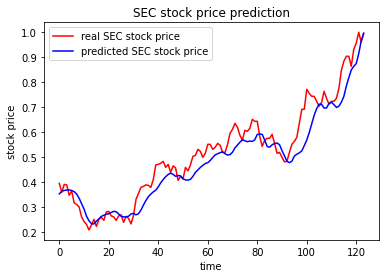

Tomorrow's SEC price : [62279.883] KRW


In [25]:
# Visualising the results
plt.figure()
plt.plot(test_y, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# df.Close[-1] : dfy.Close[-1] = y : pred_y[-1]
print("Tomorrow's SEC price :", df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')